In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import csv

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import hyperparameter optimization packages
try:
    from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
except ImportError:
    print("\nWARNING: hyperopt package is not installed. You will be unable to use section 5.")
    pass

#Import decoder functions
from Neural_Decoding.decoders import DenseNNDecoder

In [3]:
#Get Data in the correct format
#enter the folder where the data is
folder='../../preprocessed_data/'

with open(folder+'all_data_SR.pickle','rb') as f:
    #If using python 3
    M1, PMd, M1_PMd,pos_binned,vels_binned=pickle.load(f,encoding='latin1') 

In [14]:
#neural_data_combined = [M1, PMd, M1_PMd]
neural_data_combined = [M1]
kinematics = [pos_binned, vels_binned]

#percantage of data used
percentage = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

#test = [pos_binned]
R2_final = np.zeros((2, 10))


test = [pos_binned]

for i in tqdm(range(len(percentage))):
    part = percentage[i]

    R2 = np.empty((2,1))

    for col in tqdm(range(1)):
        neural_data = neural_data_combined[col]
        row = 0
        for output in kinematics:
            # Preprocess data
            bins_before=6 #How many bins of neural data prior to the output are used for decoding
            bins_current=1 #Whether to use concurrent time bin of neural data
            bins_after=0 #How many bins of neural data after the output are used for decoding

            # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
            # Function to get the covariate matrix that includes spike history from previous bins
            X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

            # Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
            #Put in "flat" format, so each "neuron / time" is a single feature
            X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

            # Output covariates
            #Set decoding output
            y=output

            #Set what part of data should be part of the training/testing/validation sets
            training_range = [0, 0.8]
            training_range = [x*part for x in training_range]
            testing_range = [0.7, 0.85]
            testing_range = [x*part for x in testing_range]
            valid_range = [0.8*part,1]
            

            num_examples=X.shape[0]

            #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
            #This makes it so that the different sets don't include overlapping neural data
            training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
            testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
            valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

            #Get training data
            X_train=X[training_set,:,:]
            X_flat_train=X_flat[training_set,:]
            y_train=y[training_set,:]

            #Get testing data
            X_test=X[testing_set,:,:]
            X_flat_test=X_flat[testing_set,:]
            y_test=y[testing_set,:]

            #Get validation data
            X_valid=X[valid_set,:,:]
            X_flat_valid=X_flat[valid_set,:]
            y_valid=y[valid_set,:]

            # Process covariates
            #Z-score "X" inputs. 
            X_train_mean=np.nanmean(X_train,axis=0)
            X_train_std=np.nanstd(X_train,axis=0)
            X_train=(X_train-X_train_mean)/X_train_std
            X_test=(X_test-X_train_mean)/X_train_std
            X_valid=(X_valid-X_train_mean)/X_train_std

            #Z-score "X_flat" inputs. 
            X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
            X_flat_train_std=np.nanstd(X_flat_train,axis=0)
            X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
            X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
            X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

            #Zero-center outputs
            y_train_mean=np.mean(y_train,axis=0)
            y_train=y_train-y_train_mean
            y_test=y_test-y_train_mean
            y_valid=y_valid-y_train_mean


            #Do optimization
            # Define parameters for hyperoptimisation
            def dnn_evaluate2(params):
                #Put parameters in proper format
                num_units=int(params['num_units'])
                frac_dropout=float(params['frac_dropout'])
                n_epochs=int(params['n_epochs'])
                model_dnn=DenseNNDecoder(units=[num_units,num_units],dropout=frac_dropout,num_epochs=n_epochs) #Define model
                model_dnn.fit(X_flat_train,y_train) #Fit model
                y_valid_predicted_dnn=model_dnn.predict(X_flat_valid) #Get validation set predictions
                return -np.mean(get_R2(y_valid,y_valid_predicted_dnn)) #Return -R2 value of validation set

            #The range of values I'll look at for the parameter
            #"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
            #So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
            #"hp.uniform" looks at continuously spaced values
            space = {
                'frac_dropout': hp.uniform('frac_dropout', 0., 0.5),
                'num_units': hp.quniform('num_units', 50,700,10),
                'n_epochs': hp.quniform('n_epochs', 2,15,1),
            }

            #object that holds iteration results
            trials = Trials()

            #Set the number of evaluations below (20 in this example)
            hyperoptBest = fmin(dnn_evaluate2, space, algo=tpe.suggest, max_evals=1, trials=trials)

            #print("R2_validation",-trials.best_trial['result']['loss'])

            #print(type(hyperoptBest['num_units']))
            #print(type(hyperoptBest['frac_dropout']))
            #print(type(hyperoptBest['n_epochs']))
            #Declare model
            model_dnn=DenseNNDecoder(units=int(hyperoptBest['num_units']),dropout=hyperoptBest['frac_dropout'],num_epochs=int(hyperoptBest['n_epochs']))

            #Fit model
            model_dnn.fit(X_flat_train,y_train)

            #Get predictions
            y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

            R2_vw = r2_score(y_valid,y_valid_predicted_dnn, multioutput='variance_weighted')

            # Store the R2 value
            R2[row,col] = R2_vw
            # increase the column counter
            row += 1
    print(R2)
    R2_final[:,i] = np.squeeze(R2)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]



  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/trial, best loss: -0.6437585730678949]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.83s/trial, best loss: -0.8191143835390206]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.62566004]
 [0.78155998]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.69s/trial, best loss: -0.6233995157621537]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.76s/trial, best loss: -0.8049506630910563]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.59393973]
 [0.76825137]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.14s/trial, best loss: -0.6259970396176006]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/trial, best loss: -0.8057640949688165]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.60089459]
 [0.7655123 ]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.51s/trial, best loss: -0.654560652894701]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.81s/trial, best loss: -0.798878644590922]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.63122683]
 [0.76433825]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.43s/trial, best loss: -0.6354911735265578]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.20s/trial, best loss: -0.7925917092666368]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.619327 ]
 [0.7648632]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/trial, best loss: -0.6292670359349126]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/trial, best loss: -0.7835020744497667]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.60270948]
 [0.77267797]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.06s/trial, best loss: -0.5959991180290365]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|███████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/trial, best loss: -0.77795135095748]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.60037793]
 [0.76971266]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.89s/trial, best loss: -0.5885519107786946]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.50s/trial, best loss: -0.7638130873158029]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.56465377]
 [0.75648495]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/trial, best loss: -0.5472472911356908]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/trial, best loss: -0.7498737689089983]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.52854936]
 [0.72121261]]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/trial, best loss: -0.44700764210161337]


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|█████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/trial, best loss: -0.6787783708693859]



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:36<00:00, 27.61s/it]

[[0.4530982 ]
 [0.68520864]]


In [4]:
# Export the data into a csv file for further analysis
csv_rowlist = [['','FFNN'], ['R^2 values','Position', 'Velocity'], ['M1', R2[0,0], R2[0,1]], ['PMd',  R2[1,0], R2[1,1]],['M1 & PMd', R2[2,0], R2[2,1]]]

#export_path = '../Results/FFNN_raw_SR.csv'
#with open(export_path, 'w', newline='') as file:
#    writer = csv.writer(file)
#   writer.writerows(csv_rowlist)

In [15]:
print(R2_final)

[[0.62566004 0.59393973 0.60089459 0.63122683 0.619327   0.60270948
  0.60037793 0.56465377 0.52854936 0.4530982 ]
 [0.78155998 0.76825137 0.7655123  0.76433825 0.7648632  0.77267797
  0.76971266 0.75648495 0.72121261 0.68520864]]


[100, 90, 80, 70, 60, 50, 40, 30, 20, 10]


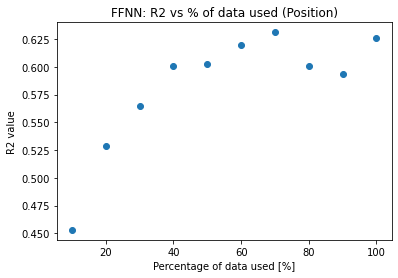

In [27]:
x = [100, 90, 80, 70, 60, 50 ,40 ,30 ,20 ,10]
print(x)
plt.plot(x, R2_final[0,:], 'o')
plt.xlabel('Percentage of data used [%]')
plt.title('FFNN: R2 vs % of data used (Position)')
plt.ylabel('R2 value')
plt.savefig('FFNN_SR_data_length_pos.png')

[100, 90, 80, 70, 60, 50, 40, 30, 20, 10]


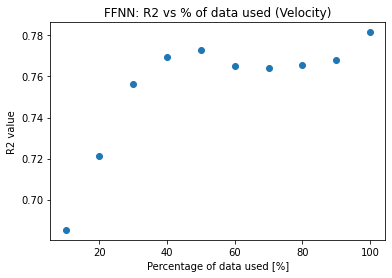

In [28]:
x = [100, 90, 80, 70, 60, 50 ,40 ,30 ,20 ,10]
print(x)
plt.plot(x, R2_final[1,:], 'o')
plt.xlabel('Percentage of data used [%]')
plt.title('FFNN: R2 vs % of data used (Velocity)')
plt.ylabel('R2 value')
plt.savefig('FFNN_SR_data_length_vel.png')